# 1. Data Exploration

## Overview 
In the first section we will look at techniques to load and explore the data to be used for machine learning. The purpose of this exploration to gain an understanding of the data and how it relates to the problem we are trying to solve. This will help us make sensible choices for differents elements of our machine learning pipeline.

### Prerequisities 

To be able to sucessfully work through this notebook, you will need some understanding of the following 
* The python programming language
* Simple data handling in python
* Basic plotting using matplotlib
* Environment set up using pip or conda

### Learning Outcomes 

* Loading tabular and gridded datasets using common python libraries
* typical techniques for *exploratory data analysis* on different
* key characteristics of datasets to use in choosing components for a machine learning pipeline


## Tutorial - Exploratory Data Analysis

The first step in a machine learning problem is to understand the data you have available for training a machine learning algorithm. In any data driven technique, the quality of the results is only going to be as good as the quality of the data. This can only be achieved by matching the appropriate techniques to the data that you have, so understanding the particular dataset to be used is the foundation of a successful outcome.

To achieve this, one typically performs an *Exploratory Data Analysis*, where one produce a series of summary statistics and plots that highlight the most salient characteristics of the dataset for the problem at hand. Typical traits to be considered include:
* The range of values different input feature can take e.g. min and max temperature, start and end dates.
* Important subsets of the data e.g. different seasons or time of the day.
* Distributions of different features, both as a whole and important subsets
* Correlations between different features, especially input and target features.







### Best Practices & Values

Performing a through data exploration implements the Met Office Machine Learning best practices in the following ways
* Ethics - Ensure we can justify our choices from understanding of the data and how it relates to the potential impacts of this work.
* Data - Ensure that we understand biases or other issues with the data
* ML Pitfall -  Avoid pitfalls through making informed choices based on analysis of data
* ML Lifecycle - Ensure we store and proces the data so we can reproduce the results

## Excercise 1: Load and explore tabular dataset - Falkland Islands Airfield Rotors

The first dataset we will explore comes from a challenge by Operational Meteorologist Steve Ramsdale.  The aim of challenge is to forecast rotors, a type of localised topographically-driven turbulent wind gusts, at the Mount Pleasant Airfield in the Falkland Islands. 

![Image of the topography of the Falkland Islands](images/falklands_mtpleasant.png) 

These occur through northerly winds interacting with mountains to the north of the airfield.  The aim is to predict whether or not these will occur, using data from global, coarse-resolution models which are not able to to explicitly resolve this phenomenon. Where these occur at an airfield they make conditions sufficiently hazardous so as to cause operations to be suspended. Rotors therefore impact the aviation industry, in partticular where flights have to be diverted for considerable distances from isolated airfields.  

What is needed is a prediction of whether such rotors are likely in a given time window, so that flight can be postponed or cancelled rather than risking the flight and turning back wasting fuel. As these are small scale features, they are not explicitly resolved in coarse resolution global models. Operational Meteorologists (OpMets) are able to look at this model data and determine whether rotors are likely, but this is error-prone and time consuming.


![Depiction of how turbulent lee wind gusts form](images/rotors_diagram.png)

[Met Office Youtube video explaining rotors](https://www.youtube.com/watch?v=jgSZG9SqN_s)

### Dataset 1 - Predicting impactful turbulent wind gusts
The target is a human-created dataset produced by Operational Meterologists at the airfield, as to whether a rotor occured in any given three hour period.


### Setup

In [1]:
import pathlib
import datetime
import os
import functools

In [2]:
import matplotlib
%matplotlib inline

In [3]:
import numpy as np

In [4]:
import pandas

In [5]:
import iris
import iris.quickplot
import iris.coord_categorisation
import cartopy

In [6]:
import sklearn
import sklearn.metrics

### Load data

In [7]:
try:
    falklands_data_dir = os.environ['ML_TUTORIAL_DIR']
except KeyError:
    falklands_data_dir = '/project/informatics_lab/data_science_cop/ML_challenges/2021_opmet_challenge/Rotors'
falklands_data_dir = pathlib.Path(falklands_data_dir)
print(falklands_data_dir)

/Users/stephen.haddad/data/ml_weather_tutorial


In [8]:
falklands_data_fname = '2021_met_office_aviation_rotors.csv'

In [9]:
falklands_data_path = falklands_data_dir / falklands_data_fname
falklands_data_path

PosixPath('/Users/stephen.haddad/data/ml_weather_tutorial/2021_met_office_aviation_rotors.csv')

In [10]:
falklands_data_path.is_file()

True

In [11]:
falklands_df = pandas.read_csv(falklands_data_path)

In [12]:
falklands_df

,Unnamed: 0,DTG,air_temp_obs,dewpoint_obs,wind_direction_obs,wind_speed_obs,wind_gust_obs,air_temp_1,air_temp_2,air_temp_3,...,windspd_18,winddir_19,windspd_19,winddir_20,windspd_20,winddir_21,windspd_21,winddir_22,windspd_22,rotors_present
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,1,01/01/2015 00:00,283.9,280.7,110.0,4.1,-9999999.0,284.000,283.625,283.250,...,5.8,341.0,6.0,334.0,6.1,330.0,6.0,329.0,5.8,0.0
2,2,01/01/2015 03:00,280.7,279.7,90.0,7.7,-9999999.0,281.500,281.250,280.750,...,6.8,344.0,5.3,348.0,3.8,360.0,3.2,12.0,3.5,0.0
3,3,01/01/2015 06:00,279.8,278.1,100.0,7.7,-9999999.0,279.875,279.625,279.125,...,6.0,345.0,5.5,358.0,5.0,10.0,4.2,38.0,4.0,0.0
4,4,01/01/2015 09:00,279.9,277.0,120.0,7.2,-9999999.0,279.625,279.250,278.875,...,3.1,338.0,3.5,354.0,3.9,9.0,4.4,22.0,4.6,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20101,20101,31/12/2020 06:00,276.7,275.5,270.0,3.6,-9999999.0,277.875,277.750,277.625,...,12.1,223.0,11.8,221.0,11.4,219.0,11.3,215.0,11.4,0.0
20102,20102,31/12/2020 09:00,277.9,276.9,270.0,3.1,-9999999.0,277.875,277.625,277.875,...,10.2,230.0,10.8,230.0,11.6,227.0,12.3,222.0,12.0,0.0
20103,20103,31/12/2020 12:00,283.5,277.1,220.0,3.6,-9999999.0,281.125,280.625,280.125,...,10.3,218.0,11.9,221.0,12.8,222.0,11.9,225.0,10.6,0.0
20104,20104,31/12/2020 15:00,286.1,276.9,250.0,3.6,-9999999.0,284.625,284.125,283.625,...,9.4,218.0,8.6,212.0,8.3,218.0,8.7,226.0,10.1,0.0


In [13]:
falklands_df.columns

Index(['Unnamed: 0', 'DTG', 'air_temp_obs', 'dewpoint_obs',
       'wind_direction_obs', 'wind_speed_obs', 'wind_gust_obs', 'air_temp_1',
       'air_temp_2', 'air_temp_3', 'air_temp_4', 'air_temp_5', 'air_temp_6',
       'air_temp_7', 'air_temp_8', 'air_temp_9', 'air_temp_10', 'air_temp_11',
       'air_temp_12', 'air_temp_13', 'air_temp_14', 'air_temp_15',
       'air_temp_16', 'air_temp_17', 'air_temp_18', 'air_temp_19',
       'air_temp_20', 'air_temp_21', 'air_temp_22', 'sh_1', 'sh_2', 'sh_3',
       'sh_4', 'sh_5', 'sh_6', 'sh_7', 'sh_8', 'sh_9', 'sh_10', 'sh_11',
       'sh_12', 'sh_13', 'sh_14', 'sh_15', 'sh_16', 'sh_17', 'sh_18', 'sh_19',
       'sh_20', 'sh_21', 'sh_22', 'winddir_1', 'windspd_1', 'winddir_2',
       'windspd_2', 'winddir_3', 'windspd_3', 'winddir_4', 'windspd_4',
       'winddir_5', 'windspd_5', 'winddir_6', 'windspd_6', 'winddir_7',
       'windspd_7', 'winddir_8', 'windspd_8', 'winddir_9', 'windspd_9',
       'winddir_10', 'windspd_10', 'winddir_11', 'winds

In [17]:
falklands_df.columns

Index(['Unnamed: 0', 'DTG', 'air_temp_obs', 'dewpoint_obs',
       'wind_direction_obs', 'wind_speed_obs', 'wind_gust_obs', 'air_temp_1',
       'air_temp_2', 'air_temp_3', 'air_temp_4', 'air_temp_5', 'air_temp_6',
       'air_temp_7', 'air_temp_8', 'air_temp_9', 'air_temp_10', 'air_temp_11',
       'air_temp_12', 'air_temp_13', 'air_temp_14', 'air_temp_15',
       'air_temp_16', 'air_temp_17', 'air_temp_18', 'air_temp_19',
       'air_temp_20', 'air_temp_21', 'air_temp_22', 'sh_1', 'sh_2', 'sh_3',
       'sh_4', 'sh_5', 'sh_6', 'sh_7', 'sh_8', 'sh_9', 'sh_10', 'sh_11',
       'sh_12', 'sh_13', 'sh_14', 'sh_15', 'sh_16', 'sh_17', 'sh_18', 'sh_19',
       'sh_20', 'sh_21', 'sh_22', 'winddir_1', 'windspd_1', 'winddir_2',
       'windspd_2', 'winddir_3', 'windspd_3', 'winddir_4', 'windspd_4',
       'winddir_5', 'windspd_5', 'winddir_6', 'windspd_6', 'winddir_7',
       'windspd_7', 'winddir_8', 'windspd_8', 'winddir_9', 'windspd_9',
       'winddir_10', 'windspd_10', 'winddir_11', 'winds

### Clean data
We perform some initial cleaning of the dataset to make it easier to work with. Ideally this could be done once and saved out for future use.

In [16]:
# rename target variable
falklands_df = falklands_df.rename({'Rotors 1 is true': 'rotors_present'},axis=1)

In [18]:
# In the dataset, NaNs are used to represent that no rotors was observed. This is not good practice, so we are replacing the NaNs with 0's
falklands_df.loc[falklands_df[falklands_df['rotors_present'].isna()].index, 'rotors_present'] = 0

In [19]:
#  Create date and times using the pandas datetime functionality
falklands_df['DTG'] = pandas.to_datetime(falklands_df['DTG'])

# There are some duplicate dates and times, so we drop those
falklands_df = falklands_df.drop_duplicates(subset=['DTG'])

# get rid of data points without a date and time
falklands_df = falklands_df[~falklands_df['DTG'].isnull()]


In [20]:
#  subset observation so that wind speed, air temp, wind direction and dewpoints
# are all greater than 0  (temperatures are in Kelvin, which must be greater than 0)
falklands_df = falklands_df[(falklands_df['wind_speed_obs'] >= 0.0) &
                            (falklands_df['air_temp_obs'] >= 0.0) &
                            (falklands_df['wind_direction_obs'] >= 0.0) &
                            (falklands_df['dewpoint_obs'] >= 0.0) 
                           ]


In [26]:
falklands_df = falklands_df.drop([c1 for c1 in falklands_df.columns if 'unnamed' in c1.lower()] , axis='columns')

In [27]:
falklands_df

,DTG,air_temp_obs,dewpoint_obs,wind_direction_obs,wind_speed_obs,wind_gust_obs,air_temp_1,air_temp_2,air_temp_3,air_temp_4,...,windspd_18,winddir_19,windspd_19,winddir_20,windspd_20,winddir_21,windspd_21,winddir_22,windspd_22,rotors_present
1,2015-01-01 00:00:00,283.9,280.7,110.0,4.1,-9999999.0,284.000,283.625,283.250,282.625,...,5.8,341.0,6.0,334.0,6.1,330.0,6.0,329.0,5.8,0.0
2,2015-01-01 03:00:00,280.7,279.7,90.0,7.7,-9999999.0,281.500,281.250,280.750,280.250,...,6.8,344.0,5.3,348.0,3.8,360.0,3.2,12.0,3.5,0.0
3,2015-01-01 06:00:00,279.8,278.1,100.0,7.7,-9999999.0,279.875,279.625,279.125,278.625,...,6.0,345.0,5.5,358.0,5.0,10.0,4.2,38.0,4.0,0.0
4,2015-01-01 09:00:00,279.9,277.0,120.0,7.2,-9999999.0,279.625,279.250,278.875,278.250,...,3.1,338.0,3.5,354.0,3.9,9.0,4.4,22.0,4.6,0.0
5,2015-01-01 12:00:00,279.9,277.4,120.0,8.7,-9999999.0,279.250,278.875,278.375,277.875,...,1.6,273.0,2.0,303.0,2.3,329.0,2.5,338.0,2.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20101,2020-12-31 06:00:00,276.7,275.5,270.0,3.6,-9999999.0,277.875,277.750,277.625,277.500,...,12.1,223.0,11.8,221.0,11.4,219.0,11.3,215.0,11.4,0.0
20102,2020-12-31 09:00:00,277.9,276.9,270.0,3.1,-9999999.0,277.875,277.625,277.875,277.875,...,10.2,230.0,10.8,230.0,11.6,227.0,12.3,222.0,12.0,0.0
20103,2020-12-31 12:00:00,283.5,277.1,220.0,3.6,-9999999.0,281.125,280.625,280.125,279.625,...,10.3,218.0,11.9,221.0,12.8,222.0,11.9,225.0,10.6,0.0
20104,2020-12-31 15:00:00,286.1,276.9,250.0,3.6,-9999999.0,284.625,284.125,283.625,283.000,...,9.4,218.0,8.6,212.0,8.3,218.0,8.7,226.0,10.1,0.0


## Exploring key characteristics of the dataset
Now that we have loaded our dataset and done some intial cleaning, we can take a look at the key characteristics that will influence the performance of machine learning algorithms for which it is used as a training dataset.


### Exploring class imbalance

In classification problems, like this one, the term class imbalance is defined as follows:

*An imbalanced classification problem is an example of a classification problem where the distribution of examples across the known classes is biased or skewed*

(taken from article [*A Gentle Introduction to Imbalanced Classification* by Jason Brownlee](https://machinelearningmastery.com/what-is-imbalanced-classification/) )

Lets look at the distribution of our target variable, in this case it is the *rotors* column of the data. This variables labels whether or not one or more rotors occured in a given 3 hour period.

In [36]:
falklands_df['rotors_present'].value_counts()

0.0    17037
1.0      449
Name: rotors_present, dtype: int64

We see that this is an *imbalanced* classification problem. As a result we will have to consider carefully how to take this into account in our ML pipeline. This is because if we don't  the classifier will get a good score by never predicting rotors,  in this particular problem an accuracy of greater than 97% is achieved by this approach.  This is of course not a useful result for this problem based on what we want to achieve. Some of the ways we can take the class imbalance into account include: 

* *train/test split* - Ensure the distribution between classes in the train, validation and test sets is close to the distribution for the whole dataset, and also that this distribution is representative of the real-world problem.
* *possible resampling strategies* - One can resample/undersample/oversample training data so the algorithm is presented with balanced training data
* *classification metrics* - Ensure that the metric represents the business need and actual costs of making one prediction or another. In this, failing to predict a rotor event that occurs is very costly and should be penalised by the metric we use, where as predicting a rotor event that does not occur (false positive) is still ndesriable, but less costly so should be less penalised by our algorithm.



In [29]:
falklands_df.columns

Index(['DTG', 'air_temp_obs', 'dewpoint_obs', 'wind_direction_obs',
       'wind_speed_obs', 'wind_gust_obs', 'air_temp_1', 'air_temp_2',
       'air_temp_3', 'air_temp_4', 'air_temp_5', 'air_temp_6', 'air_temp_7',
       'air_temp_8', 'air_temp_9', 'air_temp_10', 'air_temp_11', 'air_temp_12',
       'air_temp_13', 'air_temp_14', 'air_temp_15', 'air_temp_16',
       'air_temp_17', 'air_temp_18', 'air_temp_19', 'air_temp_20',
       'air_temp_21', 'air_temp_22', 'sh_1', 'sh_2', 'sh_3', 'sh_4', 'sh_5',
       'sh_6', 'sh_7', 'sh_8', 'sh_9', 'sh_10', 'sh_11', 'sh_12', 'sh_13',
       'sh_14', 'sh_15', 'sh_16', 'sh_17', 'sh_18', 'sh_19', 'sh_20', 'sh_21',
       'sh_22', 'winddir_1', 'windspd_1', 'winddir_2', 'windspd_2',
       'winddir_3', 'windspd_3', 'winddir_4', 'windspd_4', 'winddir_5',
       'windspd_5', 'winddir_6', 'windspd_6', 'winddir_7', 'windspd_7',
       'winddir_8', 'windspd_8', 'winddir_9', 'windspd_9', 'winddir_10',
       'windspd_10', 'winddir_11', 'windspd_11', 'windd

Above we see the forecast variables from the Met Office Global Forecast model, which we want to use an input to our algorithm. We see there are 4 variables, each on 22 height levels, including
* temperature
* specific humidity
* wind speed
* wind direction

Next we split into two groups, to see how the distribution of input variables differs for times with and without rotors.

In [30]:
# create a rotors and no rotors dataframe
no_rotors_df = falklands_df[falklands_df['rotors_present'] ==False]
rotors_present_df = falklands_df[falklands_df['rotors_present'] == True]

In [31]:
no_rotors_df.shape

(17037, 95)

In [32]:
rotors_present_df.shape

(449, 95)

In [34]:
print(f'There are {no_rotors_df.shape[0]} events where no rotors are presents, and {rotors_present_df.shape[0]} where rotors are present.')

There are 17037 events where no rotors are presents, and 449 where rotors are present.


### Explore the distributions of meteorological variables

We should also explore the distributions of key input or predictor variables more generally. This will tell us about the range of values that are typical for each variable. We also want to know though how that range might be different for our two classes: *rotor's present* and *rotors absent*.

We will start by doing this for our *surface observation* variables.

/var/folders/w0/2x361bn95wj7lfgl33vksx1w0000gn/T/ipykernel_4973/1275007709.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


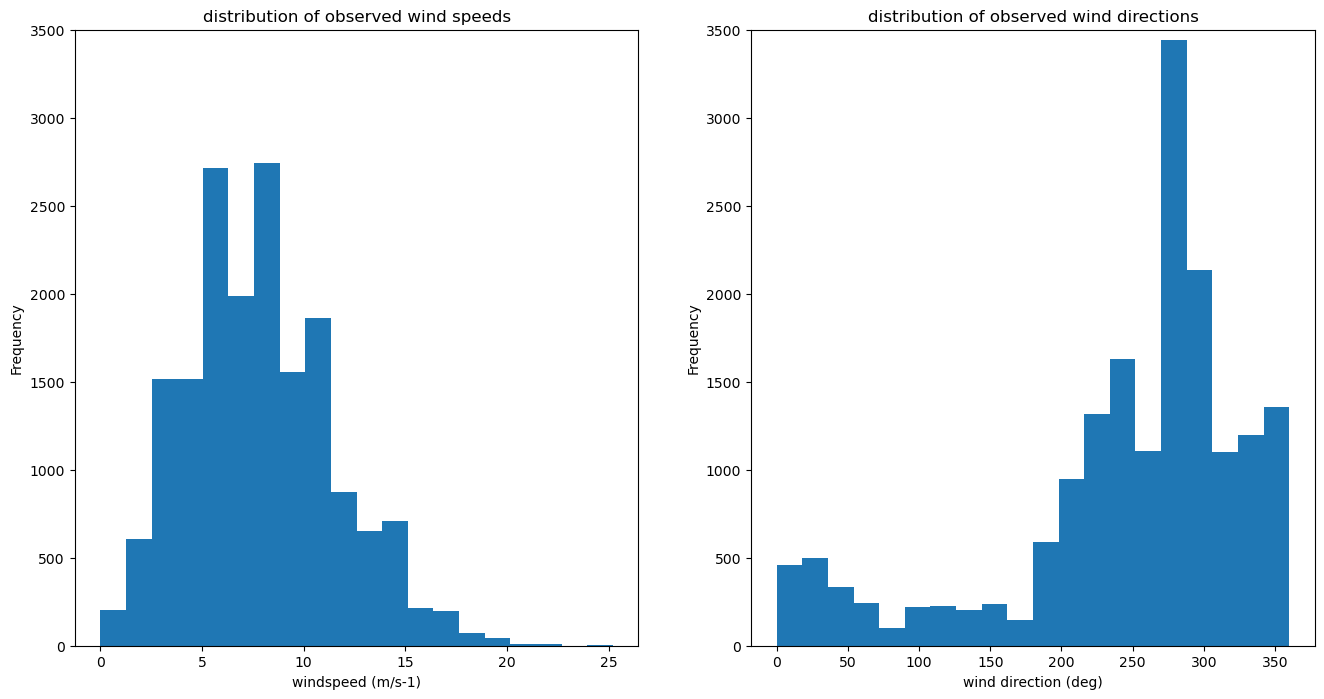

In [39]:
# Create figures
fig1 = matplotlib.pyplot.figure('distribution_wind_spevalue_countsirection', 
                                figsize=(16,8))

ax1 = fig1.add_subplot(1,2,1,title='distribution of observed wind speeds')

# In the first plot create histogram of wind speed with 20 bins
falklands_df['wind_speed_obs'].plot.hist(ax=ax1,bins=20)
ax1.set_xlabel('windspeed (m/s-1)',)  # x-label
ax1.set_ylim((0,3500))      # y-limits

# second plot
ax1 = fig1.add_subplot(1,2,2,title='distribution of observed wind directions')
falklands_df['wind_direction_obs'].plot.hist(ax=ax1,bins=20)
ax1.set_xlabel('wind direction (deg)',)
ax1.set_ylim((0,3500))
fig1.show()

/var/folders/w0/2x361bn95wj7lfgl33vksx1w0000gn/T/ipykernel_4973/3924308351.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


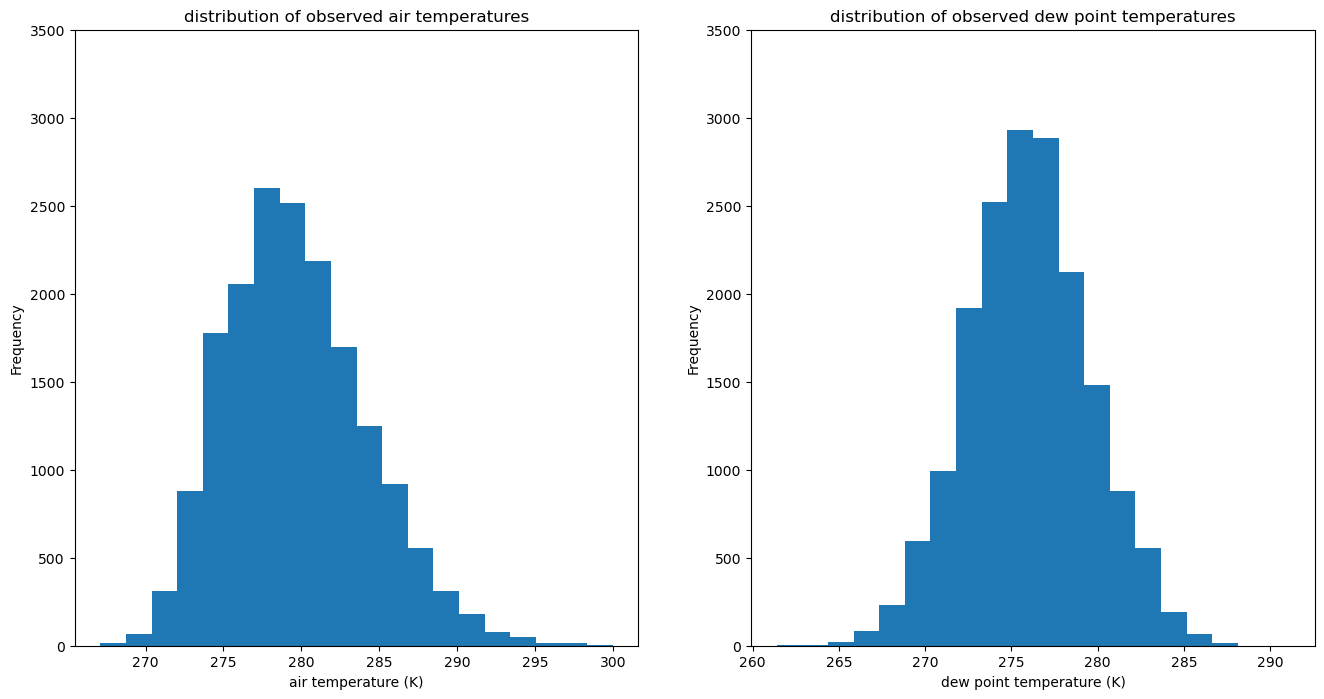

In [40]:
fig1 = matplotlib.pyplot.figure('distribution_temp_dewpoint', figsize=(16,8))
ax1 = fig1.add_subplot(1,2,1,title='distribution of observed air temperatures')
falklands_df['air_temp_obs'].plot.hist(ax=ax1,bins=20)
ax1.set_xlabel('air temperature (K)',)
ax1.set_ylim((0,3500))
ax1 = fig1.add_subplot(1,2,2,title='distribution of observed dew point temperatures')
falklands_df['dewpoint_obs'].plot.hist(ax=ax1,bins=20)
ax1.set_xlabel('dew point temperature (K)',)
ax1.set_ylim((0,3500))
fig1.show()

Now we compare the distributions of observations between our two classes in the classification problem.

['air_temp_obs', 'dewpoint_obs', 'wind_direction_obs', 'wind_speed_obs']


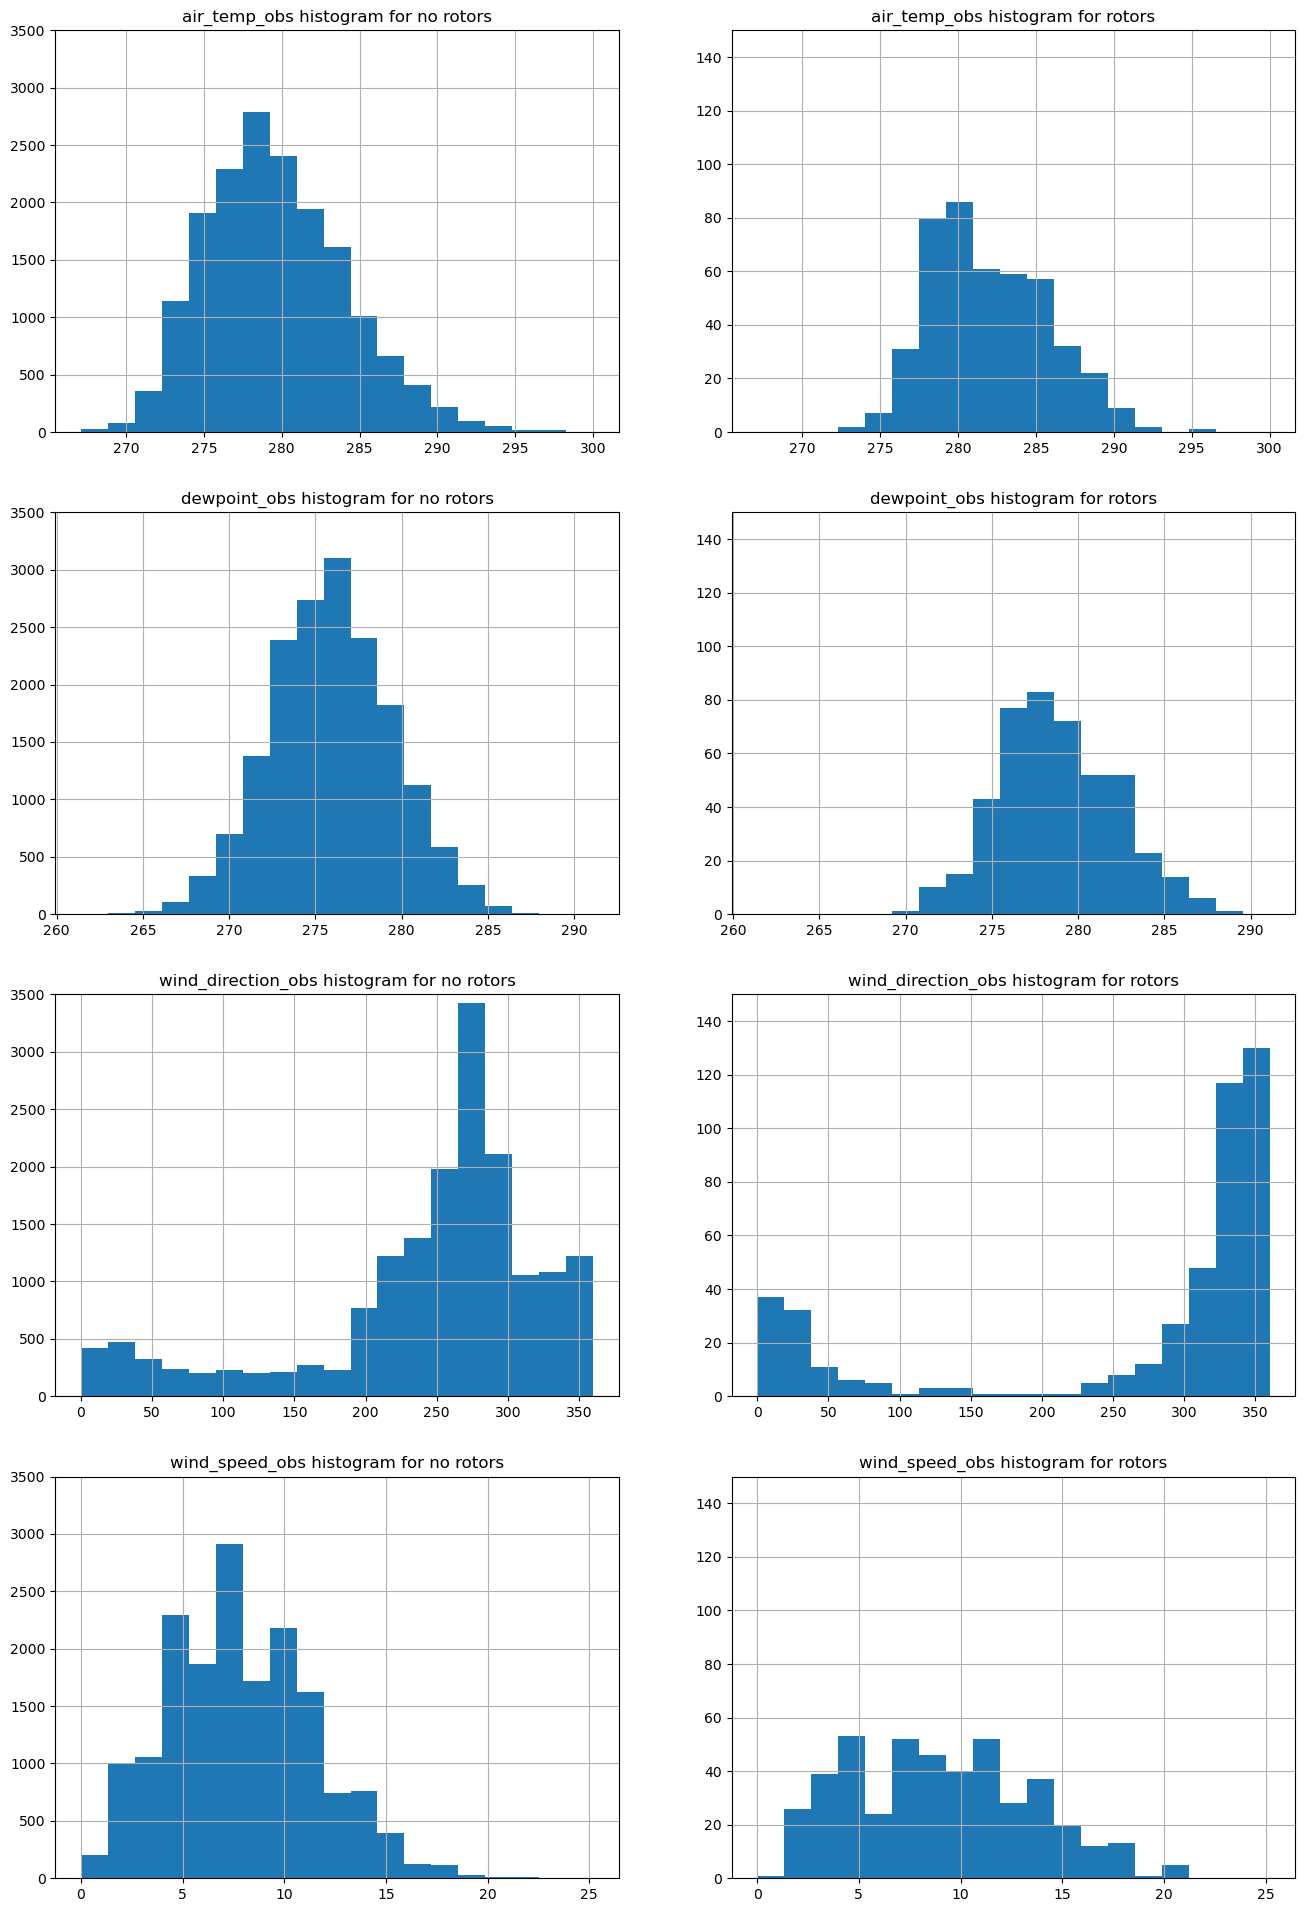

In [41]:
#List of variables that we want to plot
vars_to_plot = ['air_temp_obs', 'dewpoint_obs', 'wind_direction_obs', 'wind_speed_obs',]
print(vars_to_plot)


# Create plots
fig1 = matplotlib.pyplot.figure('comparing rotor events',
                                figsize=(16,6*len(vars_to_plot)))
for ix1, var_name in enumerate(vars_to_plot):
    # no rotors plot
    ax1 = fig1.add_subplot(len(vars_to_plot),2,ix1*2+1, 
                           title=f'{var_name} histogram for no rotors')
    bins=np.linspace(min(no_rotors_df[var_name]), max(no_rotors_df[var_name]), 20)
    no_rotors_df[var_name].hist(bins=bins,ax=ax1)
    ax1.set_ylim((0,3500))
    xlim = ax1.get_xlim()

    # Rotor plots
    ax1 = fig1.add_subplot(len(vars_to_plot),2,ix1*2+2, 
                           title=f'{var_name} histogram for rotors')
    rotors_present_df[var_name].hist(bins=bins,ax=ax1)
    ax1.set_ylim((0,150))
    ax1.set_xlim(xlim)

The above diagrams already show some differences for conditions at the surface when a rotor is observed compared to when it is not.  Most obvious is the wind direction , where rotors are found mostly in northerly winds, as is already known. Other surface variables show smaller differences.

### Temporal occurence of observations

We might also be interested in the link between occurences frequency at different times of day or in different seasons. The plots below show a small peak in the middle of the day (which may due to observation bias), but no other obviously exploitable patterns in the data.

(0.0, 80.0)

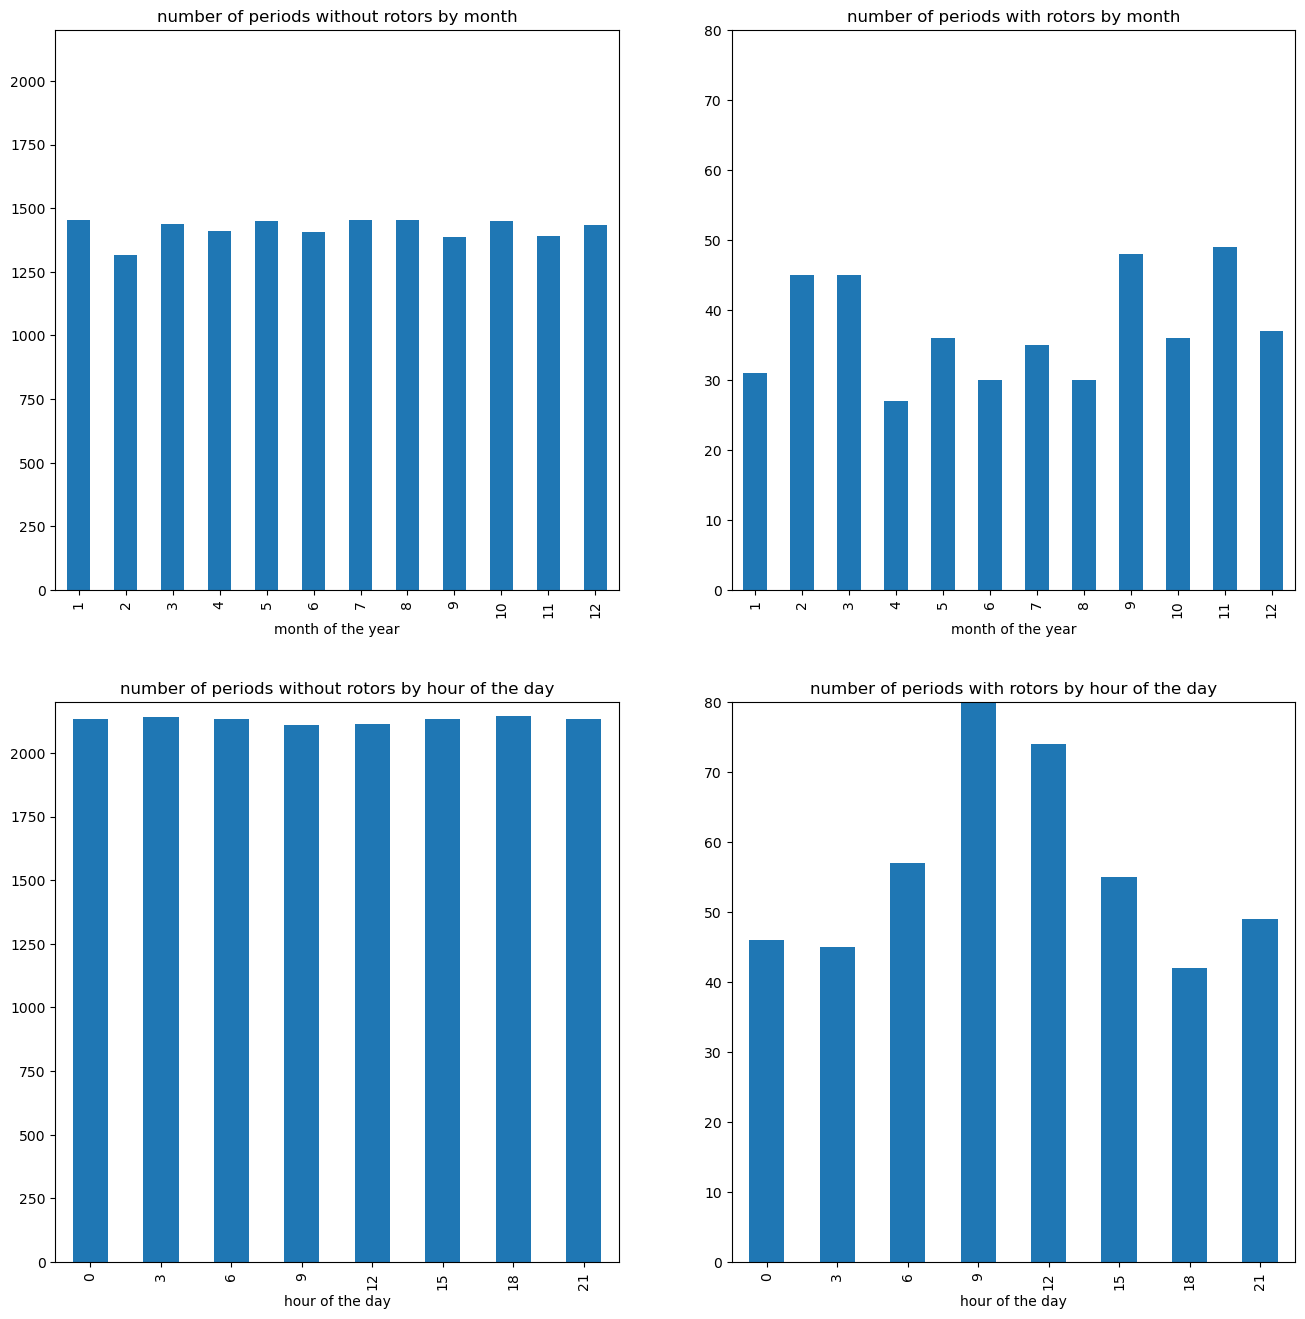

In [42]:
fig1 = matplotlib.pyplot.figure('time of year',figsize=(16,16))

# Monthly plots - no rotors
ax1 = fig1.add_subplot(2,2,1, title='number of periods without rotors by month')
# lambda function converst data to month - then a count of months is applied
no_rotors_df.groupby([ no_rotors_df['DTG'].apply(lambda x: x.month)])['DTG'].count().plot.bar( ax=ax1)
ax1.set_xlabel('month of the year')
ax1.set_ylim((0,2200))

# Monthly plots - rotors
ax1 = fig1.add_subplot(2,2,2, title='number of periods with rotors by month') 
rotors_present_df.groupby([ rotors_present_df['DTG'].apply(lambda x: x.month)])['DTG'].count().plot.bar(ax=ax1)
ax1.set_xlabel('month of the year')
ax1.set_ylim((0,80))

# Hour of the day plots - no rotors
ax1 = fig1.add_subplot(2,2,3, title='number of periods without rotors by hour of the day') 
no_rotors_df.groupby([ no_rotors_df['DTG'].apply(lambda x: x.hour)])['DTG'].count().plot.bar( ax=ax1)
ax1.set_xlabel('hour of the day')
ax1.set_ylim((0,2200))

# Hour of the day plots - with rotors
ax1 = fig1.add_subplot(2,2,4, title='number of periods with rotors by hour of the day') 
rotors_present_df.groupby([ rotors_present_df['DTG'].apply(lambda x: x.hour)])['DTG'].count().plot.bar(ax=ax1)
ax1.set_xlabel('hour of the day')
ax1.set_ylim((0,80))

#### Distributions at different height levels

Let's explore the meteorological observations at different height levels, and how they vary in the presence of rotors

In [43]:
#  Create a dictionary for the model data by variable type
features_dict = {
    'air_temp': [c1 for c1 in falklands_df.columns if 'air_temp' in c1 and 'obs' not in c1],
    'dewpoint': [c1 for c1 in falklands_df.columns if 'sh' in c1 and 'obs' not in c1],
    'wind_speed': [c1 for c1 in falklands_df.columns if 'windspd' in c1 and 'obs' not in c1],
    'wind_dir': [c1 for c1 in falklands_df.columns if 'winddir' in c1 and 'obs' not in c1],
}

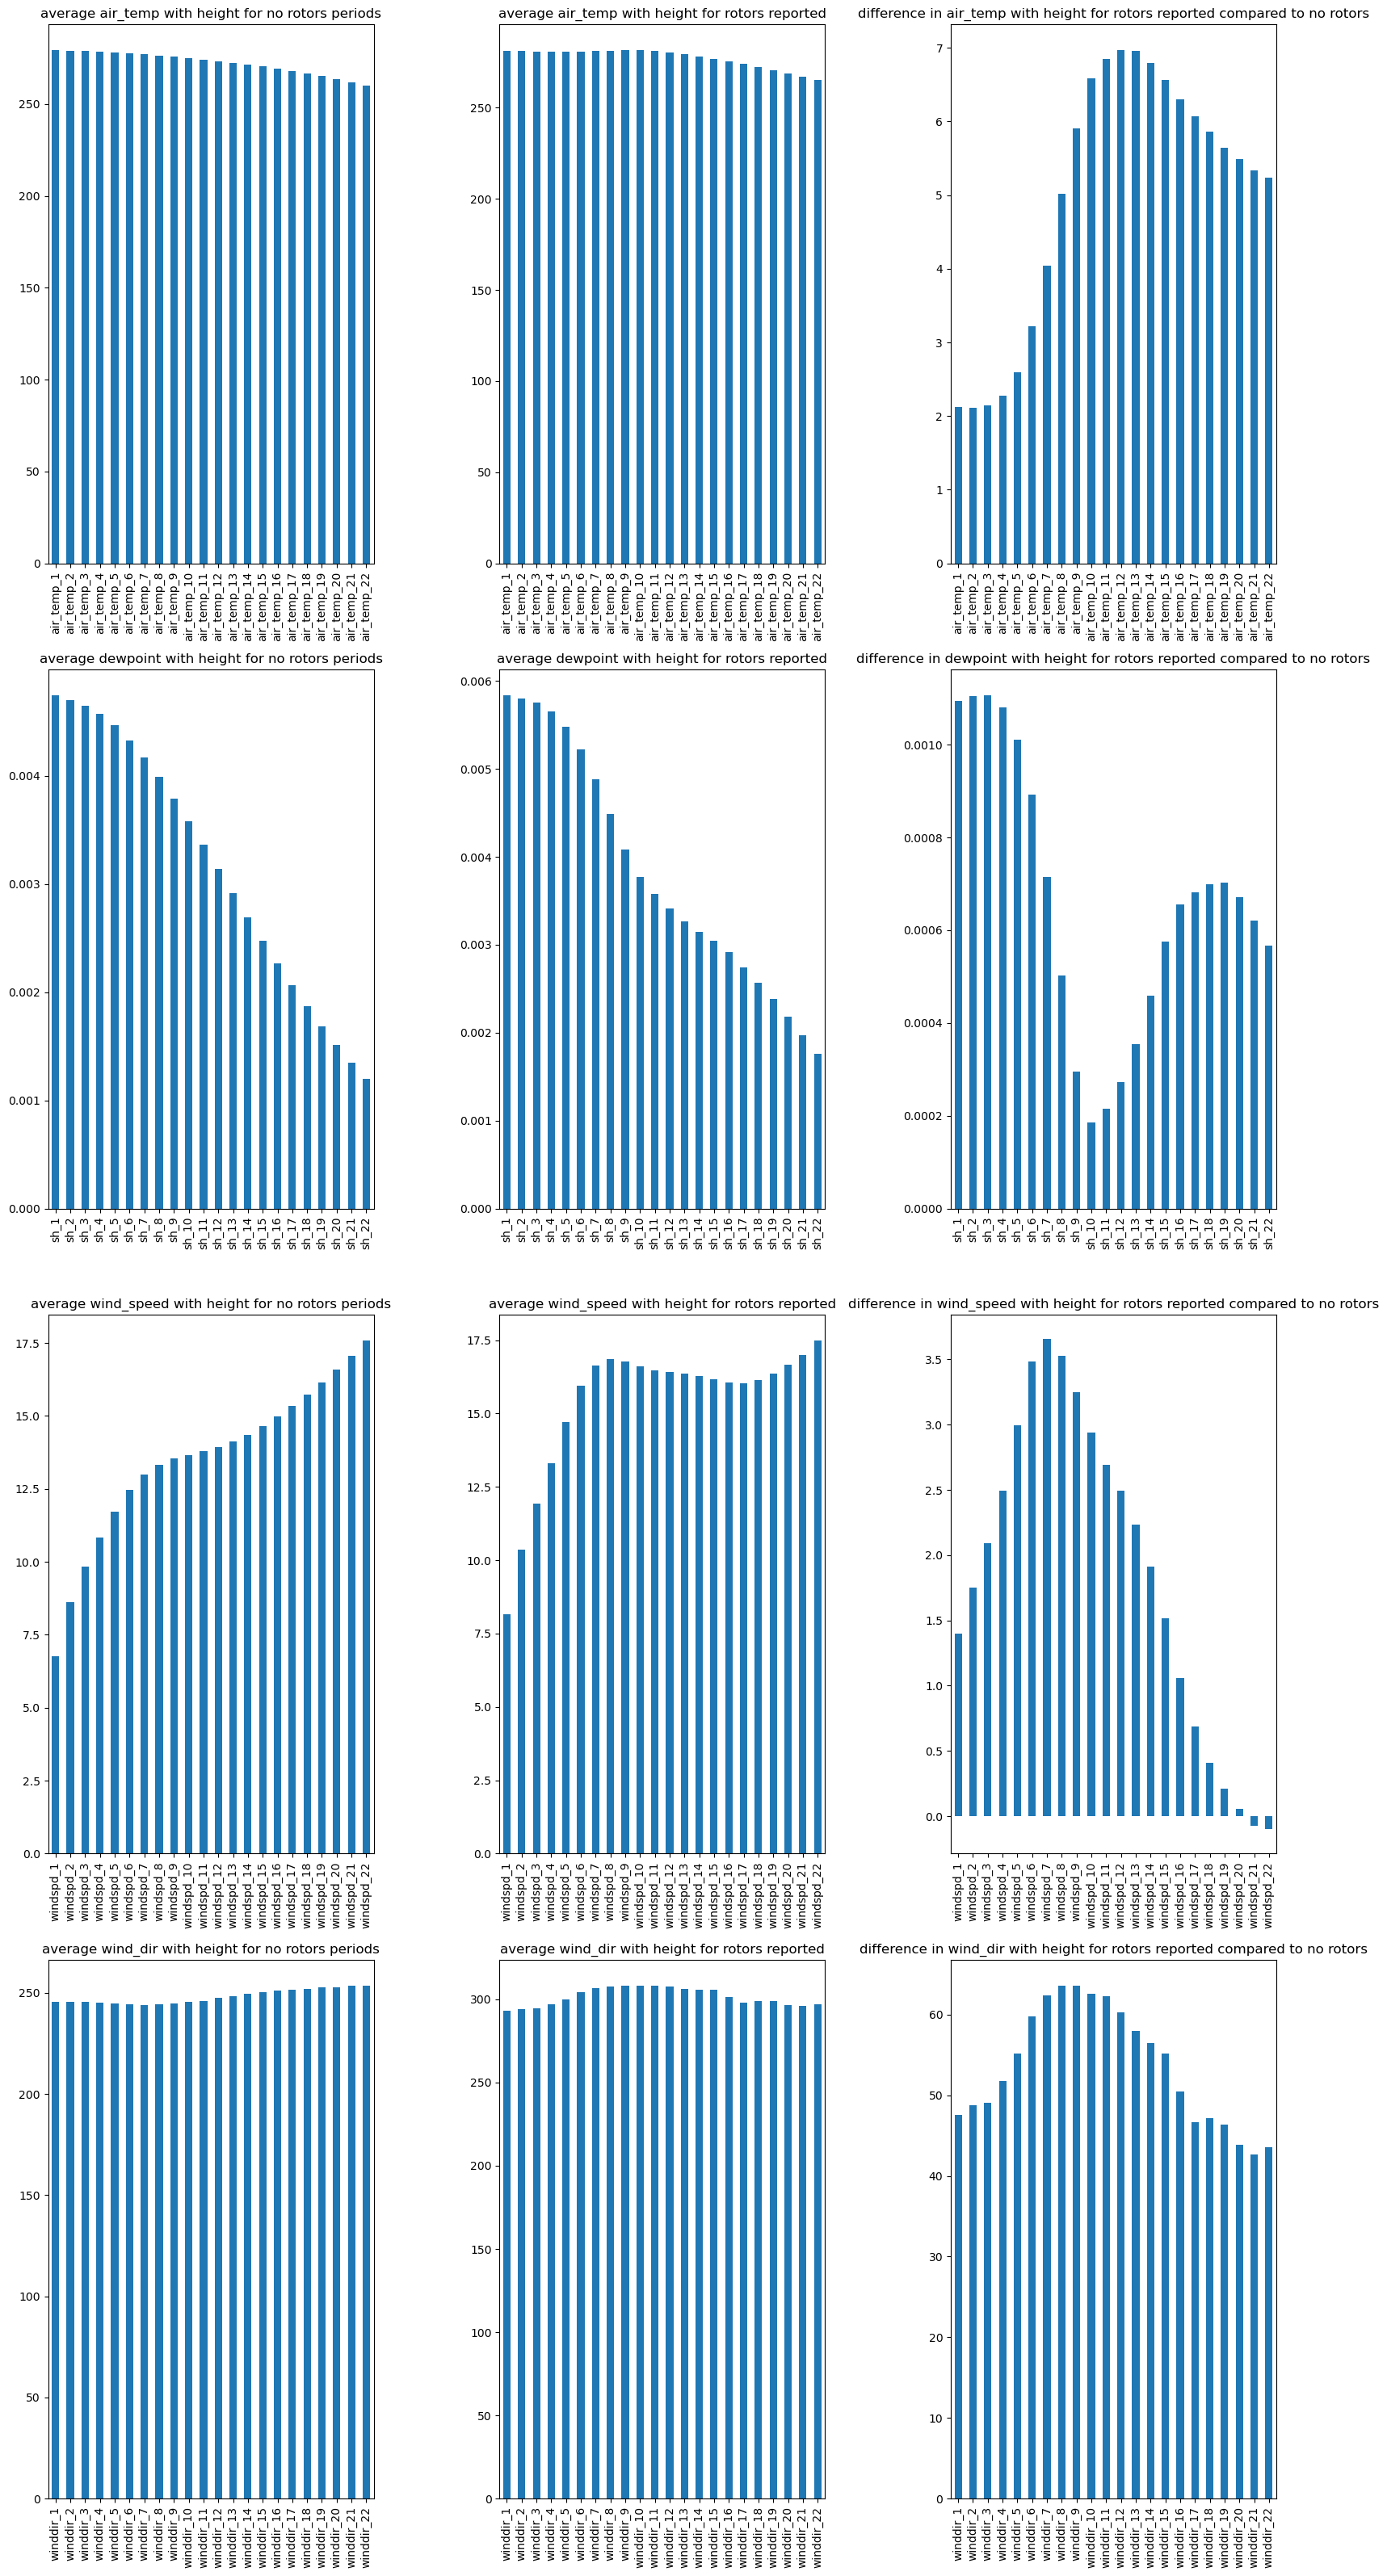

In [44]:
# How many keys are there in the dictionary
num_vars = len(features_dict.keys())
num_plots = 3

# plots of mean values for no rotors, rotors and the difference
fig1 = matplotlib.pyplot.figure(figsize=(16,8*num_vars))
for ix1, (feature_name, fl1) in enumerate(features_dict.items()):
    ax1 = fig1.add_subplot(num_vars,num_plots,ix1*num_plots+1,
        title=f'average {feature_name} with height for no rotors periods')
    no_rotors_df[fl1].mean().plot.bar(ax=ax1)
    ax1 = fig1.add_subplot(num_vars,num_plots,ix1*num_plots+2, 
        title=f'average {feature_name} with height for rotors reported')
    rotors_present_df[fl1].mean().plot.bar(ax=ax1)
    ax1 = fig1.add_subplot(num_vars,num_plots,ix1*num_plots+3, 
        title=f'difference in {feature_name} with height for rotors reported compared to no rotors')
    (rotors_present_df[fl1].mean() - no_rotors_df[fl1].mean() ).plot.bar(ax=ax1)
matplotlib.pyplot.tight_layout(w_pad=7)

Next up we want to explore the relationship between the forecast data and the observations.

### Additional Exercises
Try to plot the histogram of model data at the surface level (height level index 1)
Plot the model surface data grouped by different times of day.

### Comparison with human performance

This dataset also has some data contyaining the prediction made by human OpMets ahead of time. This is the baseline that we would need to match or improve upon for the algorithm to be useful.

In [45]:
opmet_results_path = falklands_data_dir / 'rotors_opmet_performance_2016_2021.csv'
opmet_results_path

PosixPath('/Users/stephen.haddad/data/ml_weather_tutorial/rotors_opmet_performance_2016_2021.csv')

In [46]:
opmet_predictions_df = pandas.read_csv(opmet_results_path)

We first need to do a bit of cleaning / preparation with the data before we can expore and visualise it.

In [48]:
# set missing values to zero
opmet_predictions_df.loc[opmet_predictions_df[opmet_predictions_df.observation.isna()].index,'observation'] = 0.0
opmet_predictions_df.loc[opmet_predictions_df[opmet_predictions_df['opmet_forecast'].isna()].index,'opmet_forecast'] = 0.0

# Create datatime variables
opmet_predictions_df['DTG'] = pandas.to_datetime(opmet_predictions_df['DTG'])

In [59]:
# remove invalid values for the opmet forecast field
opmet_predictions_df = opmet_predictions_df[(opmet_predictions_df['opmet_forecast'] <= 1.0) & (opmet_predictions_df['opmet_forecast'] >= 0.0)]

In [60]:
opmet_predictions_df

,DTG,observation,opmet_forecast,Hit,False Positive,True Negative,Miss,truePositive,falsePositive,trueNegative,falseNegative
0,2016-09-19 00:00:00,0.0,0.0,False,False,True,False,False,False,True,False
1,2016-09-19 01:00:00,0.0,0.0,False,False,True,False,False,False,True,False
2,2016-09-19 02:00:00,0.0,0.0,False,False,True,False,False,False,True,False
3,2016-09-19 03:00:00,0.0,0.0,False,False,True,False,False,False,True,False
4,2016-09-19 04:00:00,0.0,0.0,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
38971,2021-02-28 19:00:00,0.0,1.0,False,True,False,False,False,True,False,False
38972,2021-02-28 20:00:00,0.0,1.0,False,True,False,False,False,True,False,False
38973,2021-02-28 21:00:00,0.0,0.0,False,False,True,False,False,False,True,False
38974,2021-02-28 22:00:00,0.0,0.0,False,False,True,False,False,False,True,False


In [61]:
opmet_predictions_df['observation'].value_counts()

0.0    37725
1.0     1250
Name: observation, dtype: int64

In [62]:
opmet_predictions_df['opmet_forecast'].value_counts()

0.0    33551
1.0     5424
Name: opmet_forecast, dtype: int64

We can use a [confusion matrix](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62) to compare the number of true-positive, true-negative, false-positive and false-negative predictions which were made.§

In [66]:
import sklearn.metrics 

In [67]:
cm = sklearn.metrics.confusion_matrix(opmet_predictions_df['observation'], opmet_predictions_df['opmet_forecast'])
cm

array([[33475,  4250],
       [   76,  1174]])

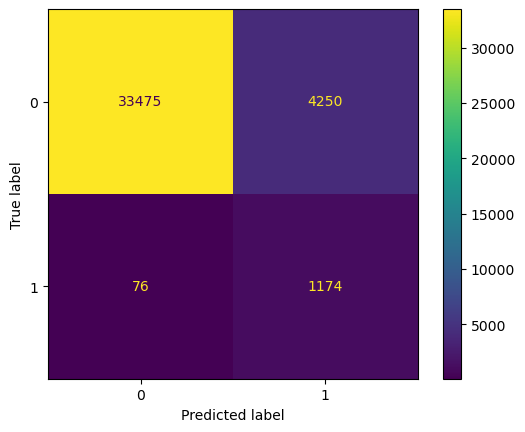

In [68]:
sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [69]:
cm

array([[33475,  4250],
       [   76,  1174]])

In [71]:
opmet_predictions_df['result_category'] = 'trueNegative'
opmet_predictions_df.loc[opmet_predictions_df[opmet_predictions_df['falseNegative']==True].index,'result_category'] = 'falseNegative'
opmet_predictions_df.loc[opmet_predictions_df[opmet_predictions_df['falsePositive']==True].index,'result_category'] = 'falsePositive'
opmet_predictions_df.loc[opmet_predictions_df[opmet_predictions_df['truePositive']==True].index,'result_category'] = 'truePositive'

/var/folders/w0/2x361bn95wj7lfgl33vksx1w0000gn/T/ipykernel_4973/3423385394.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opmet_predictions_df['result_category'] = 'trueNegative'
/Users/stephen.haddad/opt/anaconda3/envs/ml_weather_tutorial_skl/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<Axes: title={'center': 'true/false positive/negative proportions'}, ylabel='result_category'>

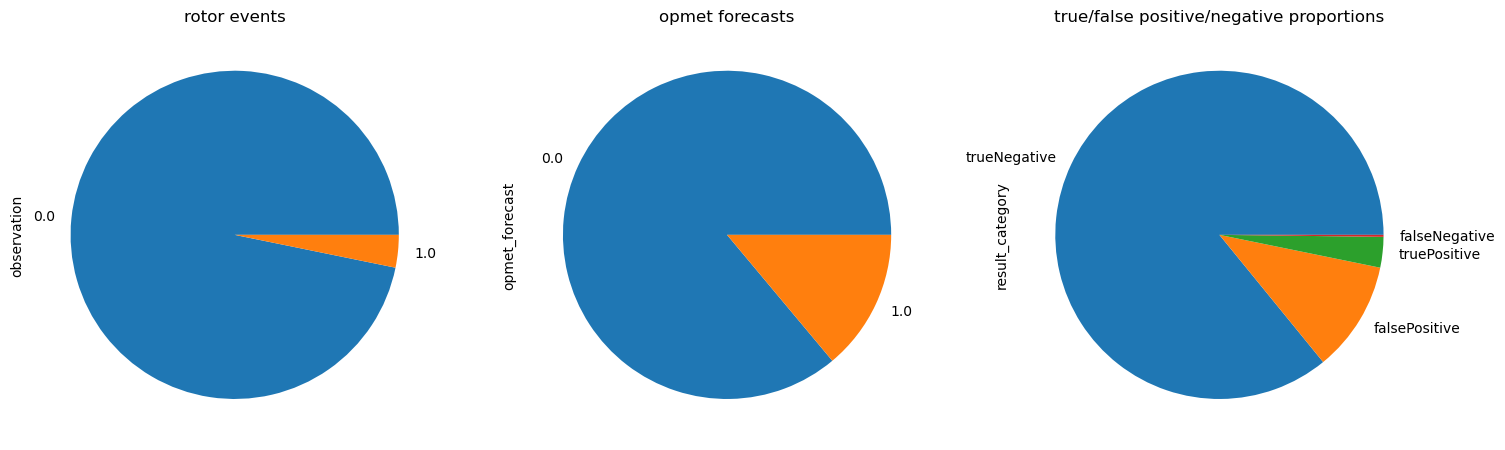

In [72]:
fig1 = matplotlib.pyplot.figure('comparisonn of hits/isses/etc.')
ax1 = fig1.add_subplot(1,3,1,title='rotor events')
opmet_predictions_df['observation'].value_counts().plot.pie(figsize=(18,6))
ax1 = fig1.add_subplot(1,3,2,title='opmet forecasts')
opmet_predictions_df['opmet_forecast'].value_counts().plot.pie(figsize=(18,6))
ax1 = fig1.add_subplot(1,3,3,title='true/false positive/negative proportions')
opmet_predictions_df['result_category'].value_counts().plot.pie(figsize=(18,6))

Exploration of this data shows us that OpMets routinely overpredict rotor events (large values of false positives). This is what you would expect, as the cost of missing a rotor event (false negative) is much higher than the cost of predicting an event and it not happening (false positive). **So the challenge for our ML algorithm is to eliminate false negatives while maintaining an acceptably low false positive rate** so as to maintain trust in forecast output. 

## Exercise 2 - Weather Regimes in ERA5 Reanalsysis Dataset

A common tool used by forecasters is to use typical patterns in meteorlogical fields, such as pressure or temperature, to characterise the weather on a given day, with the expectation that the for days belonging to a particular pattern will be broadly similar when considering an area as a whole e.g. the UK, North Atlantic, rather than specific point. In this past these typical patterns were specified manually by experts. We can also divide up our weather data automatically using machine learning, which is what we will explore in this exercise

We will use the ERA5 reanalsysis dataset as our representation of the state of the atmosphere every hour. ERA5 is Renanlysis data created by ECMWF. Reanalysis combines observations from many sources. by assimilating these into a forecast model (ECMWF's IFS in this case), to provide a consistent physically valid gridded dataset that is a close to observations as possible. The dataset consists of many different variables representing different physical values (e.g. temperature, wind, pressure). In this case we are going to use just one, **Mean Sea Level Pressure (MSLP)**, which will characterise the large scale *weather pattern*. We can then group similar pattern by consider all the values in the 2D array as a *feature vector* describing the pattern, and clustering those that are close in featue space.

* ![Example of ERA5 data](https://datastore.copernicus-climate.eu/c3s/published-forms-v2/c3sprod/reanalysis-era5-single-levels/overview.jpg)

Further reading
* [Met Office Decider weather regimes](https://www.metoffice.gov.uk/services/business-industry/energy/decider)
* [More info on ERA5 dataset](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5)

## Load and explore gridded model data - ERA5

In [73]:
try:
    era5_root = os.environ['ML_TUTORIAL_DIR']
except KeyError:
    era5_root = '/project/informatics_lab/data_science_cop/era5/'
era5_data_dir = pathlib.Path(era5_root) 
print(era5_data_dir)

/Users/stephen.haddad/data/ml_weather_tutorial


### Prepare the raw data

For this example, you need to either download the summary file as described in the set up page on the wiki (recommended), or load the "raw" data files from an AWS S3 nucket. The bucket is publicly available, but you need to be signed in with an AWS ID to be able to access it.
* Data on google drive https://drive.google.com/file/d/10HhCp0unrTBc-ynnu348umZ5ndbfRXyX/view?usp=sharing
* AWS S3 bucket - original data files https://registry.opendata.aws/ecmwf-era5/

**The next few cells show how to prepare the summary file from the raw data for interest, you can rather  ignore and move on to loading the file as downloading the raw data can be time consuming and not especially important for the purposes of this tutorial.**

In [ ]:
nc_files = sorted([str(i1) for i1 in era5_data_dir.iterdir() if '.nc' in str(i1) and 'air_pressure' in str(i1)])
nc_files

In [ ]:
era5_cubeList = iris.load(nc_files)
iris.util.equalise_attributes(era5_cubeList)
mslp_era5_cube = iris.cube.CubeList.concatenate_cube(era5_cubeList)

In [ ]:
mslp_era5_cube

In [ ]:
uk_na_bounds = {'latitude': (40,65), 'longitude': (-10,10)}

In [ ]:
mslp_era5_uk_cube = mslp_era5_cube.intersection(latitude=uk_na_bounds['latitude'], 
                                                longitude=uk_na_bounds['longitude'])


**Continue here if you are not looking at raw data**

### Load summary cube
Having demonstrated how to prepare the file of interest from the original ERA5 files, we now load the cube directly.

In [74]:
era5_fname = 'era5_mslp_UK_2017_2020.nc'
era5_path = era5_data_dir / era5_fname 
print(era5_path.is_file())
era5_path

True


PosixPath('/Users/stephen.haddad/data/ml_weather_tutorial/era5_mslp_UK_2017_2020.nc')

In [75]:
mslp_era5_uk_cube = iris.load_cube(str(era5_path))

### Explore ERA5 data to use for creating weather pattern clusters

In [76]:
mslp_era5_uk_cube

Air Pressure At Mean Sea Level (Pa),time,latitude,longitude
Shape,35064,101,81
Dimension coordinates,,,
time,x,-,-
latitude,-,x,-
longitude,-,-,x
Attributes,,,Conventions CF-1.7institution ECMWFnameCDM Mean_sea_level_pressure_surfacenameECMWF Mean sea level pressureproduct_type analysisshortNameECMWF mslsource Reanalysis


When we cluster the data, typically one normalises by season, to account for differences in seasonal means, so that cluster apply across all seasons rather than being specific to 1 season. To do this, we need to add a coordinate to our cube representing the season.

In [79]:
iris.iris.coord_categorisation.add_season_number(mslp_era5_uk_cube,'time')

In [ ]:
# functools.reduce(lambda x,y: x*y, mslp_2020_cube.shape), functools.reduce(lambda x,y: x*y, mslp_uk_2020_cube.shape)

In [80]:
mslp_era5_uk_cube

Air Pressure At Mean Sea Level (Pa),time,latitude,longitude
Shape,35064,101,81
Dimension coordinates,,,
time,x,-,-
latitude,-,x,-
longitude,-,-,x
Auxiliary coordinates,,,
season_number,x,-,-
Attributes,,,Conventions CF-1.7institution ECMWFnameCDM Mean_sea_level_pressure_surfacenameECMWF Mean sea level pressureproduct_type analysisshortNameECMWF mslsource Reanalysis


We can use the metadata in the iris cube data strucuture to review the area covered by the data.

In [81]:
min(mslp_era5_uk_cube.coord('latitude').points), max(mslp_era5_uk_cube.coord('latitude').points)

(40.0, 65.0)

In [82]:
min(mslp_era5_uk_cube.coord('longitude').points), max(mslp_era5_uk_cube.coord('longitude').points)

(-10.0, 10.0)

The next thing to explore is the seasonal means of our data. We can use the `aggregated_by` function. The next cell will execute suprisingly quickly. This is because the calculation won't actuallty be done until it is needed, for example to create a visualisation, or by forcing the calculation to happen by calling `compute()`. In this cell, none of the calculations described will actually be executed, due to the lazy loading paradigm employed in Iris.

In [83]:
mslp_uk_seasonal_mean = mslp_era5_uk_cube.aggregated_by(['season_number'],iris.analysis.MEAN)
mslp_uk_seasonal_mean

<iris 'Cube' of air_pressure_at_mean_sea_level / (Pa) (-- : 4; latitude: 101; longitude: 81)>

Now we can plot the seasonal averages as a way of exploring the data.
*NOTE* This cell will take a while to execute. This is because up until now none of the calculations described will actually have been executed, due to the *lazy loading* paradigm employed in Iris. Only at the point when the data is need (in our case to actually create the plots), are the compute operations actually triggered. So what is taking time is the subsetting and aggregation of the data, rather than only the actual plotting operations

In [ ]:
%%time
mslp_uk_seasonal_mean.data

In [ ]:
fig1 = matplotlib.pyplot.figure(figsize=(16,8))
for ix1 in range(mslp_uk_seasonal_mean.shape[0]):
    ax1 = fig1.add_subplot(1,4,ix1+1,projection=cartopy.crs.PlateCarree())
    iris.quickplot.contourf(mslp_uk_seasonal_mean[ix1],axes=ax1)
    ax1.coastlines()

## Next Steps

There are further example notebooks looking at loading and exploring data in python in the following locations:
* [Introduction to Data Analsyis in Python](https://github.com/informatics-lab/intro_python_data_analysis/)
* [Pangeo Lectures](https://github.com/informatics-lab/PangeoLectures)
* [Using Climate Data](https://github.com/Informatics-lab/UsingClimateData)


## Dataset Info

### Falklands Rotors Challenge Dataset
Crown Copyright 2021 - This dataset was created by Met Office Chief Operational Meterologist Steve Ramsdale from Met Office forecast and observation data.
* Model Data - Met Office Global 10km resolution model
* Observations - made by meteorologists at Mount Pleasant airfield in the Falkland Islands.

### ERA5
ERA5 is Renanlysis data created by ECMWF. Reanalysis combines observations from many sources. by assimilating these into a forecast model (ECMWF's IFS in this case), to provide a consistent physically valid gridded dataset that is a close to observations as possible
https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5



## References

The format of this notebook is based on the [template for tutorial notebooks](https://github.com/geo-yrao/notebook-dev/blob/main/templates/NCAI_Training_Notebook_template%20-%20Distribution%20Copy.ipynb) developed by NOAA, available on GitHub.